In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn as nn
import cv2

### Load and process image

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

def create_mask(image):
    masked_image = image.copy()
    mask = np.full((IMG_WIDTH, IMG_HEIGHT, 3), 0, np.uint8)
    for _ in range(np.random.randint(1, 5)):
        # Get random x locations to start line
        x1, x2 = np.random.randint(1, IMG_WIDTH), np.random.randint(1, IMG_WIDTH)
        # Get random y locations to start line
        y1, y2 = np.random.randint(1, IMG_HEIGHT), np.random.randint(1, IMG_HEIGHT)

        # Get random thickness of the line drawn
        thickness = np.random.randint(1, 15)
        # Draw line on the black mask
        cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)
    masked_image = np.where(mask, 255*np.ones_like(mask), masked_image)
    return masked_image

def process_img(img):
    image = np.array(Image.open(img).convert('RGB'))
    image = create_mask(image)
    image = transforms.functional.to_tensor(image)
    image = image.type(torch.float32)
    image = image*2 - 1
    image = image.unsqueeze(0)
    return image

In [3]:
img_path = 'E:\\\AIO_document\\AIO2024-Exercise_Folder\\AIO2024-Exercise\\module7\\week1\\image_test\\image_inpaiting\\0.jpg'

target_image = Image.open(img_path).convert('RGB')
input_image = process_img(img_path)

In [4]:
print(input_image.shape)

torch.Size([1, 3, 256, 256])


### Model UNet with Skip Connection

In [5]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class FeatureOut(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            # vì input range đang ở khoảng [-1, 1], nếu input range ở khoảng [0, 1] thì dùng hàm sigmoid
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_sample = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        up_sample = self.up_sample(x)
        concat = torch.concat([up_sample, skip], dim=1)
        return self.conv_block(concat)


class UNetArchitecture(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.first_feature = FirstFeature(in_channels, 64)
        self.conv = ConvBlock(64, 64)

        self.encoder1 = Encoder(64, 128)
        self.encoder2 = Encoder(128, 256)
        self.encoder3 = Encoder(256, 512)
        self.encoder4 = Encoder(512, 1024)

        self.decoder1 = Decoder(1024, 512)
        self.decoder2 = Decoder(512, 256)
        self.decoder3 = Decoder(256, 128)
        self.decoder4 = Decoder(128, 64)

        self.out_conv = FeatureOut(64, n_classes)

    def forward(self, x):
        x = self.first_feature(x)
        x1 = self.conv(x)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)
        x = self.out_conv(x)

        return x

### Model UNet without Skip Connection

In [6]:
class FirstFeatureNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class FeatureOutNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlockNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class EncoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            ConvBlockNoSkip(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)


class DecoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_sample = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU()
        )
        self.conv_block = ConvBlockNoSkip(out_channels*2, out_channels)

    def forward(self, x):
        up_sample = self.up_sample(x)
        return self.conv_block(up_sample)


class UNetArchitectureNoSkip(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.first_feature = FirstFeatureNoSkip(in_channels, 64)
        self.conv = ConvBlockNoSkip(64, 64)

        self.encoder1 = EncoderNoSkip(64, 128)
        self.encoder2 = EncoderNoSkip(128, 256)
        self.encoder3 = EncoderNoSkip(256, 512)
        self.encoder4 = EncoderNoSkip(512, 1024)

        self.decoder1 = DecoderNoSkip(1024, 512)
        self.decoder2 = DecoderNoSkip(512, 256)
        self.decoder3 = DecoderNoSkip(256, 128)
        self.decoder4 = DecoderNoSkip(128, 64)

        self.out_conv = FeatureOutNoSkip(64, n_classes)

    def forward(self, x):
        x = self.first_feature(x)
        x = self.conv(x)

        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        x = self.encoder4(x)

        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)
        x = self.out_conv(x)

        return x

### Load model and plot result

In [7]:
def load_model(model, path, input_image):
    state_dict = torch.load(path, map_location=torch.device('cpu'), weights_only=True)
    model.load_state_dict(state_dict)
    img_output = model(input_image)
    img_output = img_output.squeeze(0).detach().cpu().numpy()
    img_output = img_output.transpose((1, 2, 0))
    img_output = Image.fromarray(((img_output + 1)*127.5).astype(np.uint8))

    return img_output 

In [8]:
unet_model = UNetArchitecture(
    in_channels=3,
    n_classes=3,
)

unet_no_skip_model = UNetArchitectureNoSkip(
    in_channels=3,
    n_classes=3,
)

In [9]:
img_skip_connection_pred = load_model(
    model=unet_model, 
    path='weights/image_inpainting_skip_connection_last.pt',
    input_image=input_image
)

img_no_skip_pred = load_model(
    model=unet_no_skip_model, 
    path='weights/image_inpainting_no_skip_last.pt',
    input_image=input_image
)

print(img_skip_connection_pred.size)
print(img_no_skip_pred.size)

(256, 256)
(256, 256)


In [10]:
input_image_plot = input_image.clone().squeeze(0).permute((1, 2, 0)).numpy()
input_image_plot = ((input_image_plot + 1)*127.5).astype(np.uint8)
print(input_image_plot.shape)

(256, 256, 3)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

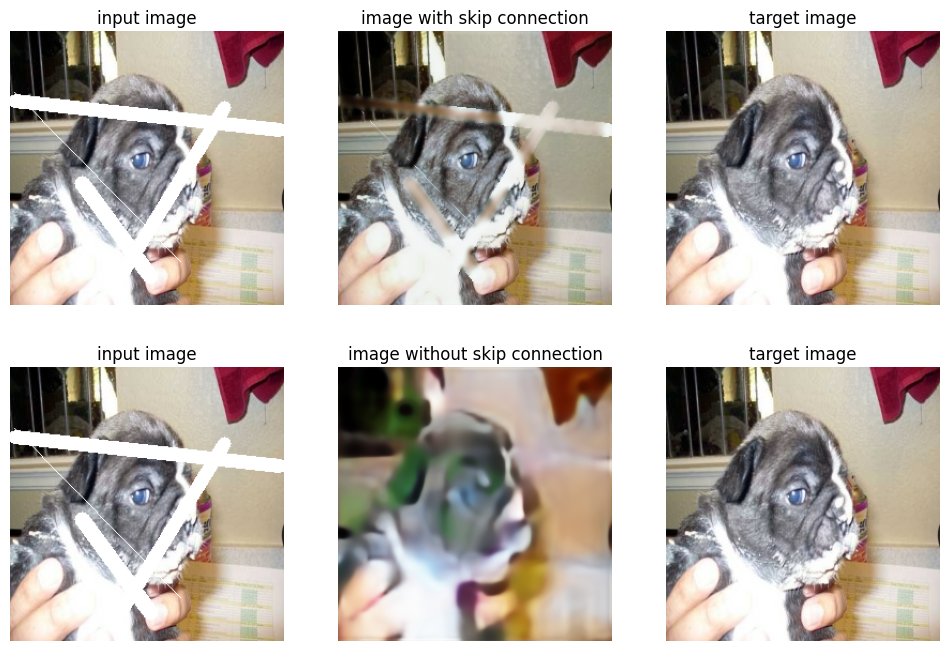

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# show image with skip connection
ax[0, 0].imshow(input_image_plot)
ax[0, 0].set_title('input image')
ax[0, 0].axis('off')

ax[0, 1].imshow(img_skip_connection_pred)
ax[0, 1].set_title('image with skip connection')
ax[0, 1].axis('off')

ax[0, 2].imshow(target_image)
ax[0, 2].set_title('target image')
ax[0, 2].axis('off')

# show image without skip connection
ax[1, 0].imshow(input_image_plot)
ax[1, 0].set_title('input image')
ax[1, 0].axis('off')

ax[1, 1].imshow(img_no_skip_pred)
ax[1, 1].set_title('image without skip connection')
ax[1, 1].axis('off')

ax[1, 2].imshow(target_image)
ax[1, 2].set_title('target image')
ax[1, 2].axis('off')

In [13]:
input_image

tensor([[[[-1.0000, -0.9922, -0.9922,  ..., -0.1451, -0.2000, -0.3176],
          [-0.9922, -0.9922, -0.9922,  ..., -0.3020, -0.4118, -0.4745],
          [-0.9922, -0.9922, -0.9922,  ..., -0.5373, -0.5608, -0.6157],
          ...,
          [ 0.4118,  0.4902,  0.5059,  ...,  0.4118,  0.3882,  0.3647],
          [ 0.4039,  0.4824,  0.5059,  ...,  0.3882,  0.3725,  0.3412],
          [ 0.3647,  0.4510,  0.4824,  ...,  0.3804,  0.3569,  0.3333]],

         [[-0.9686, -0.9608, -0.9608,  ..., -0.8353, -0.8118, -0.8824],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9059, -0.9451, -0.9529],
          [-0.9608, -0.9608, -0.9608,  ..., -0.9608, -0.9216, -0.9451],
          ...,
          [ 0.0431,  0.1216,  0.1216,  ...,  0.2627,  0.2627,  0.2392],
          [ 0.0196,  0.0980,  0.1059,  ...,  0.2392,  0.2471,  0.2157],
          [-0.0196,  0.0667,  0.0824,  ...,  0.2314,  0.2314,  0.2078]],

         [[-0.9765, -0.9686, -0.9686,  ..., -0.6471, -0.6392, -0.7098],
          [-0.9686, -0.9686, -